# LIME可解释性分析-自己训练得到的30类水果图像分类

对自己训练得到的30类水果图像分类模型，运行LIME可解释性分析。

可视化某个输入图像，某个图块区域，对模型预测为某个类别的贡献影响。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-9-21

## 导入工具包

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入测试图片

In [2]:
img_path = 'test_img/test_fruits.jpg'

In [3]:
img_pil = Image.open(img_path)

In [4]:
# img_pil

## 载入模型

In [5]:
model = torch.load('checkpoint/fruit30_pytorch_20220814.pth')
model = model.eval().to(device)

In [6]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [24]:
len(idx_to_labels)

30

In [7]:
idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

## 预处理

In [8]:
trans_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

trans_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    trans_norm
    ])

trans_B = transforms.Compose([
        transforms.ToTensor(),
        trans_norm
    ])

trans_C = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

## 原始输入图像分类预测

In [9]:
input_tensor = trans_A(img_pil).unsqueeze(0).to(device)
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1)
top_n = pred_softmax.topk(5)

In [10]:
top_n

torch.return_types.topk(
values=tensor([[0.5711, 0.1514, 0.1232, 0.0305, 0.0274]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[16, 28, 23,  4, 12]], device='cuda:0'))

## 定义分类预测函数

In [11]:
def batch_predict(images):
    batch = torch.stack(tuple(trans_B(i) for i in images), dim=0)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [12]:
test_pred = batch_predict([trans_C(img_pil)])
test_pred.squeeze().argmax()

16

## LIME可解释性分析

In [13]:
from lime import lime_image

In [23]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(trans_C(img_pil)), 
                                         batch_predict, # 分类预测函数
                                         top_labels=len(idx_to_labels), 
                                         hide_color=0, 
                                         num_samples=3000) # LIME生成的邻域图像个数

  0%|          | 0/3000 [00:00<?, ?it/s]

In [25]:
explanation.top_labels[0]

16

## 可视化

In [26]:
from skimage.segmentation import mark_boundaries

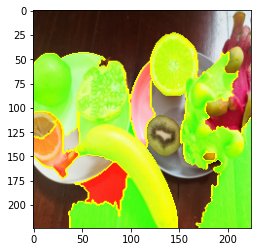

In [27]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

## 脐橙

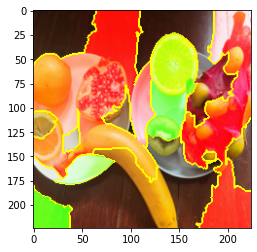

In [29]:
temp, mask = explanation.get_image_and_mask(15, positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

## 柠檬

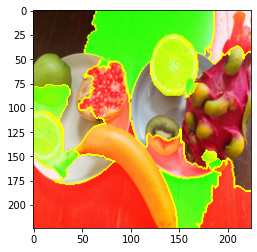

In [32]:
temp, mask = explanation.get_image_and_mask(5, positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

## 石榴

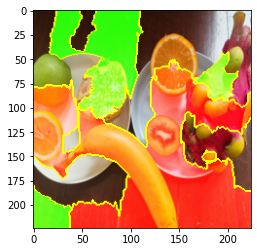

In [18]:
temp, mask = explanation.get_image_and_mask(12, positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

## 香蕉

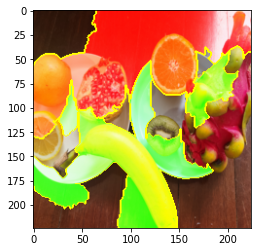

In [19]:
temp, mask = explanation.get_image_and_mask(28, positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

## 小练习

绿色表示该区域对当前类别影响为正，红色表示该区域对当前类别影响为负

1.更换图像分类模型

2.更换类别

3.更换可视化参数

4.更换图片